## Domácí úkol

Za domácí úkol budete mít vyřešit pomocí optimalizace mravenčí kolonií [Vehicle Routing Problem](https://en.wikipedia.org/wiki/Vehicle_routing_problem), což je vlastně jen zobecněný problém obchodního cestujícího na princip optimalizace rozvozu zásilek doručovací společnosti. Jedná se o to, že máme depa, každé má svá vlastní vozidla s danou kapacitou a nějakou množinu zásilek, které je potřeba rozvézt k jejich majitelům. Cílem je najít množinu doručovacích tras tak, aby byly všechny zásilky dodány majitelům a aby byly minimalizované celkové náklady, tedy aby byl použit co nejmenší počet vozidel a aby byly trasy co nejkratší.

V našem případě použijeme zjednodušenou verzi tohoto problému s jedním depem, které má neomezený počet vozidel jednoho typu. Vstupní data najdete ve složce *domaci_ukol_data*, jsou ve formátu xml a obsahují 3 soubory -- 2 malé a jeden větší, které zároveň obsahují:
- Seznam uzlů se souřadnicemi x a y, kdy uzel s typem 0 je depo, a ty ostatní s typem 1 jsou lokace zákazníků.
- Seznam vozidel, v tomto případě máme jeden typ vozidla, které musí začínat a končit v depu a má nějakou maximální kapacitu předmětů, které uveze.
- Seznam požadavků, neboli do jakého uzlu se toho má co dovézt.

Svůj kód, popis řešení, výsledky a jejich rozbor mi pošlete emailem do stanoveného deadline. Pro sepsání popisu algoritmu a výsledků použijte [tento template](https://github.com/kackamac/Prirodou-inspirovane-algoritmy/blob/master/11_rojove%20algoritmy/DU3_spojita_optimalizace.pdf).

In [82]:
from collections import namedtuple
import math
import functools
import numpy as np
import csv
import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import collections as mc

In [83]:
Vertex = namedtuple('Vertex', ['x', 'y'])
# Request = namedtuple('Request', ['weight'])
# Vehicle = namedtuple('Vehicle', ['capacity'])

In [84]:
import xml.etree.ElementTree as ET

tree = ET.parse('.\\domaci_ukol_data\\data_32.xml')
root = tree.getroot()

vertices = []
requests = []

nodes = root.find('network').find('nodes')
vehicle_profile = root.find('fleet').find('vehicle_profile')
items = root.find('requests')

vehicle_capacity = float(vehicle_profile.find('capacity').text)

for node in nodes.findall('node'):
    if node.attrib['type'] == "0":
        start_vertex = Vertex(float(node.find('cx').text), float(node.find('cy').text))
    else:
        vertices.append(Vertex(float(node.find('cx').text), float(node.find('cy').text)))
        
vertices.append(start_vertex)

for item in items.findall('request'):
    requests.append(float(item.find('quantity').text))

print(start_vertex)
print(vertices)
print(requests)
print(vehicle_capacity)

Vertex(x=82.0, y=76.0)
[Vertex(x=96.0, y=44.0), Vertex(x=50.0, y=5.0), Vertex(x=49.0, y=8.0), Vertex(x=13.0, y=7.0), Vertex(x=29.0, y=89.0), Vertex(x=58.0, y=30.0), Vertex(x=84.0, y=39.0), Vertex(x=14.0, y=24.0), Vertex(x=2.0, y=39.0), Vertex(x=3.0, y=82.0), Vertex(x=5.0, y=10.0), Vertex(x=98.0, y=52.0), Vertex(x=84.0, y=25.0), Vertex(x=61.0, y=59.0), Vertex(x=1.0, y=65.0), Vertex(x=88.0, y=51.0), Vertex(x=91.0, y=2.0), Vertex(x=19.0, y=32.0), Vertex(x=93.0, y=3.0), Vertex(x=50.0, y=93.0), Vertex(x=98.0, y=14.0), Vertex(x=5.0, y=42.0), Vertex(x=42.0, y=9.0), Vertex(x=61.0, y=62.0), Vertex(x=9.0, y=97.0), Vertex(x=80.0, y=55.0), Vertex(x=57.0, y=69.0), Vertex(x=23.0, y=15.0), Vertex(x=20.0, y=70.0), Vertex(x=85.0, y=60.0), Vertex(x=98.0, y=5.0), Vertex(x=82.0, y=76.0)]
[19.0, 21.0, 6.0, 19.0, 7.0, 12.0, 16.0, 6.0, 16.0, 8.0, 14.0, 21.0, 16.0, 3.0, 22.0, 18.0, 19.0, 1.0, 24.0, 8.0, 12.0, 4.0, 8.0, 24.0, 24.0, 2.0, 20.0, 15.0, 2.0, 14.0, 9.0]
100.0


In [85]:
# def distance_matrix(vertices):
#     distances = np.zeros((len(vertices), len(vertices)))
#     for i in range(len(vertices)):
#         v1 = vertices[i]
#         for j in range(i, len(vertices)):
#             v2 = vertices[j]
#             dist = math.sqrt((v1.x - v2.x)**2+(v1.y - v2.y)**2)
#             distances[i,j] = dist
#             distances[j,i] = dist


In [86]:
@functools.lru_cache(maxsize=None)
def distance(v1, v2):
    return math.sqrt((v1.x - v2.x)**2+(v1.y - v2.y)**2)

In [87]:
def fitness(vertices, distance, solution):
    solution_distance = 0
    for circle in solution:
        for x, y in zip(circle, circle[1:]):
            solution_distance += distance(vertices[x], vertices[y])
        solution_distance += distance(vertices[circle[-1]], vertices[circle[0]])
    return solution_distance #+ 2* len(solution)

In [88]:
def initialize_pheromone(N):
    return 0.01*np.ones(shape=(N,N))

def update_pheromone(pheromones_array, solutions, fits, Q=100, rho=0.6):
    pheromone_update = np.zeros(shape=pheromones_array.shape)
    for solution, fit in zip(solutions, fits):
        for circle in solution:
            for x, y in zip(circle, circle[1:]):
                pheromone_update[x][y] += Q/fit
            pheromone_update[circle[-1]][circle[0]] += Q/fit
    
    return (1-rho)*pheromones_array + pheromone_update

In [89]:
def generate_solutions(requests, vertices, vehicle_capacity, pheromones, distance, ants_count, alpha=1, beta=3):
    
    def compute_prob(v1, v2):
        dist = 1/distance(vertices[v1], vertices[v2])
        tau = pheromones[v1, v2]
        ret = pow(tau, alpha) * pow(dist,beta)
        return ret if ret > 0.000001 else 0.000001

    def generate_circle(available, start_vertex):
        circle = [len(vertices) - 1]
        weight = 0
        while available:
            probs = np.array(list(map(lambda x: compute_prob(circle[-1], x), available)))
            selected = np.random.choice(available, p=probs/sum(probs))
            weight += requests[selected]

            if weight > vehicle_capacity:
                return circle
            
            circle.append(selected)
            available.remove(selected)
        return circle
    
    other_vertices = vertices[:-1]
    start_vertex == len(vertices) - 1

    for i in range(ants_count):
        available = list(range(len(other_vertices)))
        solution = []
        while available:
            solution.append(generate_circle(available, start_vertex))
        yield solution

In [90]:
def ant_solver(requests, vertices, vehicle_capacity, distance, ants=10, max_iterations=3000, alpha=1, beta=3, Q=100, rho=0.8):
    pheromones = initialize_pheromone(len(vertices))
    best_solution = None
    best_fitness = float('inf')
    
    for i in range(max_iterations):
        solutions = list(generate_solutions(requests, vertices, vehicle_capacity, pheromones, distance, ants, alpha=alpha, beta=beta))
        fits = list(map(lambda x: fitness(vertices, distance, x), solutions))
        
        pheromones = update_pheromone(pheromones, solutions, fits, Q=Q, rho=rho)
        
        for s, f in zip(solutions, fits):
            if f < best_fitness:
                best_fitness = f
                best_solution = s
        
        print(f'{i:4}, {np.min(fits):.4f}, {np.mean(fits):.4f}, {np.max(fits):.4f}')

    return best_solution, pheromones

In [91]:
best_solution, pheromones = ant_solver(requests, vertices, vehicle_capacity, distance, max_iterations=5000)

   0, 1483.0024, 1693.7676, 1947.6647
   1, 1168.2791, 1367.8128, 1662.3017
   2, 1270.1088, 1414.8777, 1515.5628
   3, 1234.6444, 1335.3047, 1466.3035
   4, 1206.3757, 1346.4675, 1537.2424
   5, 1083.8521, 1330.0357, 1574.2667
   6, 1085.0292, 1241.0912, 1364.6576
   7, 1161.9526, 1312.1297, 1576.0112
   8, 1080.4176, 1247.8653, 1460.5959
   9, 1177.2628, 1299.8730, 1423.2398
  10, 1096.8353, 1241.5074, 1410.8877
  11, 1069.9533, 1235.6095, 1422.0952
  12, 998.2080, 1226.0273, 1422.5189
  13, 1062.2182, 1272.4755, 1479.8706
  14, 1081.5305, 1320.1858, 1557.5192
  15, 1109.5307, 1297.2994, 1477.6141
  16, 926.5882, 1238.2105, 1458.3999
  17, 1124.3816, 1270.8586, 1395.4135
  18, 1082.7011, 1259.4076, 1512.1648
  19, 1117.2969, 1227.6110, 1322.2056
  20, 1100.4123, 1262.1835, 1440.3184
  21, 1094.1499, 1250.7036, 1453.7978
  22, 1071.0369, 1238.0115, 1428.4482
  23, 1068.6234, 1226.5042, 1364.3568
  24, 1149.4388, 1284.9247, 1456.4382
  25, 1140.1239, 1268.7653, 1401.0343
  26, 1211.747

Fitness:  903.8222226305301
[31,
 23,
 13,
 26,
 25,
 15,
 11,
 31,
 29,
 1,
 2,
 22,
 27,
 3,
 10,
 31,
 19,
 4,
 24,
 9,
 14,
 21,
 8,
 17,
 7,
 28,
 31,
 12,
 20,
 30,
 18,
 16,
 0,
 31,
 5,
 6]


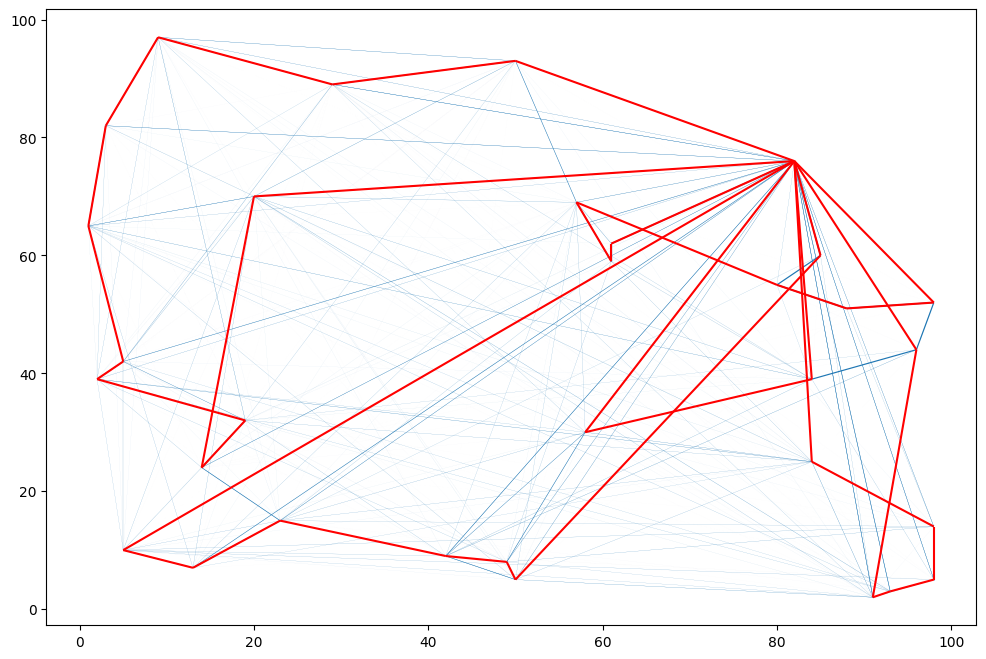

In [92]:
lines = []
colors = []
for i, v1 in enumerate(vertices):
    for j, v2 in enumerate(vertices):
        lines.append([(v1.x, v1.y), (v2.x, v2.y)])
        colors.append(pheromones[i][j])

lc = mc.LineCollection(lines, linewidths=np.array(colors))

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.add_collection(lc)
ax.autoscale()

solution = best_solution

# tady muzeme zkouset vliv jednotlivych parametru na vygenerovane reseni
# solution = list(generate_solutions(vertices, pheromones, distance, N=1, alpha=3, beta=1))[0]

print('Fitness: ', fitness(vertices, distance, solution))


# for circle in solution:
#     for x, y in zip(circle, circle[1:]):
#         plt.plot([vertices[x].x, vertices[y].x], [vertices[x].y, vertices[y].y], c='red')
#     plt.plot([vertices[circle[-1]].x, vertices[circle[0]].x], [vertices[circle[-1]].y, vertices[circle[0]].y], c='red')

solution_vertices = [i for circle in solution for i in circle]
solution = solution_vertices
pprint.pprint(solution_vertices)

solution_lines = []
for i, j in zip(solution, solution[1:]):
    solution_lines.append([(vertices[i].x, vertices[i].y), (vertices[j].x, vertices[j].y)])
solution_lines.append([(vertices[solution[-1]].x, vertices[solution[-1]].y), (vertices[solution[0]].x, vertices[solution[0]].y)])
solutions_lc = mc.LineCollection(solution_lines, colors='red')
ax.add_collection(solutions_lc)